# **Teoria da Decisão - TC1**

### Marcos Rezende 2019027067
### Tiago Porto 2019027202

Instalação dos módulos utilizados

In [34]:
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
import math
import random
class Struct:
  pass


Carrega os dados do problema para a variável probdata

In [35]:
def probdef():
  originaldata = pd.read_csv('clientes.csv', header=None)
  dataframe = pd.DataFrame(originaldata)
  probdata = Struct()
  probdata.coord = []
  for i in range(len(dataframe[0])):
    probdata.coord.append([dataframe[0][i], dataframe[1][i]])

  probdata.x = dataframe[0]
  probdata.y = dataframe[1]
  probdata.intensity = dataframe[2]
  return probdata

Definição da função Shake.
As estruturas de vizinhança implementadas foram:


*   Movimenta um número aleatório de PAs de 5 a 15 metros em qualquer direção
*   Movimenta todos os PAs de 5 a 15 metros em qualquer direção
*   Adiciona um novo PA


In [36]:
def shake(x,k):
    y = copy.deepcopy(x)
    r = np.random.randint(0, len(x.solution)) # número de PAs que serão movidos
    if k == 1:             # Movimenta um número aleatório de PAs 5 metros em uma direção aleatória

      for i in range(r):
        movX = np.random.randint(-1,1)*5
        movY = np.random.randint(-1,1)*5


        if(y.solution[i][0] + movX < 400 and y.solution[i][0] + movX > 0):
            y.solution[i][0] = y.solution[i][0] + movX
        else:
          y.solution[i][0] = y.solution[i][0] - movX

        if(y.solution[i][1] + movY < 400 and y.solution[i][1] + movY > 0):
            y.solution[i][1] = y.solution[i][1] + movY
        else:
          y.solution[i][1] = y.solution[i][1] - movY

    elif k == 2:    # Movimenta TODOS os PAs 5 metros em uma direção aleatória
      for i in range(len(x.solution)):
        movX = np.random.randint(-1,1)*5*np.random.randint(1,3)
        movY = np.random.randint(-1,1)*5*np.random.randint(1,3)
        # print(movX, movY)

        if(y.solution[i][0] + movX < 400 and y.solution[i][0] + movX > 0):
            y.solution[i][0] = y.solution[i][0] + movX
        else:
          y.solution[i][0] = y.solution[i][0] - movX

        if(y.solution[i][1] + movY < 400 and y.solution[i][1] + movY > 0):
            y.solution[i][1] = y.solution[i][1] + movY
        else:
          y.solution[i][1] = y.solution[i][1] - movY

    elif k == 3:
        # Adiciona um novo PA em uma posição aleatória
        # if(len(x.solution) < 25):
        tempPA = [np.random.randint(0,81)*5, np.random.randint(0,81)*5]
        y.solution.append(tempPA)
    elif k == 4:
      if(len(y.solution) > 1):
        pos = np.random.randint(0, len(y.solution) - 1)
        del y.solution[pos]
    return y

Definição da Heuristica Construtiva.
A Lógica utilizada foi distribuir igualmente os PAs ao longo de toda a extensão do local

In [37]:
def generate_initial_solution(f):
  # Distribuir igualmente 9 PAs por todo o ambiente

  y = []
  if f == "f1":
    for i in range(3):
      for j in range(3):
        coordY = ((j)*133) + 70
        coordX = ((i)*133) + 70
        y.append([coordX,coordY])
  elif f == "f3":
    for i in range(5):
      for j in range(5):
        coordY = ((j)*80) + 60
        coordX = ((i)*80) + 60
        y.append([coordX,coordY])

  else:
    for i in range(5):
      for j in range(5):
        coordY = ((j)*80)
        coordX = ((i)*80)
        y.append([coordX,coordY])
  x = Struct()
  x.solution = y
  return x

# generate_initial_solution()

Troca de vizinhança


In [38]:
def neighborhoodChange(x, y, k):

    if y.fitness < x.fitness:
        x = copy.deepcopy(y)
        k = 1
    else:
        k += 1

    return x, k

Função para calcular a distância euclidiana entre 2 pontos

In [39]:
def calcDist(coord1, coord2):
  return abs(math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2))


Definição da função objetivo e restrições


In [40]:
colors = [
    "#00FFFF", "#0000FF", "#008000", "#FFFF00", "#FFA500",
    "#800080", "#00FF00", "#FF00FF", "#008080", "#FFD700",
    "#A52A2A", "#696969", "#2E8B57", "#800000", "#9400D3",
    "#00CED1", "#8A2BE2", "#6B8E23", "#20B2AA", "#32CD32",
    "#808000", "#008B8B", "#483D8B", "#2F4F4F", "#008080", "#00FFFF", "#0000FF", "#008000", "#FFFF00", "#FFA500",
    "#800080", "#00FF00", "#FF00FF", "#008080", "#FFD700",
    "#A52A2A", "#696969", "#2E8B57", "#800000", "#9400D3",
    "#00CED1", "#8A2BE2", "#6B8E23", "#20B2AA", "#32CD32",
    "#808000", "#008B8B", "#483D8B", "#2F4F4F", "#008080"
  ]

In [41]:
def normalizaFuncoes(fx, f):
    if(f == "f1"):
        return (fx - 0)/(25 - 0)
    else:
        return (fx - 6891)/(56510-6891)

In [116]:
def fobj(x, probdata, f, e):


  penalidade = 0.0



  #  R5: Penaliza a solução se tiver mais de 25 PAs
  if(len(x.solution) > 25):
    # pass
    penalidade += (len(x.solution) - 25)**2 * 100


  # R3 e R4: Penaliza a solução se nem todos os clientes estiverem no raio de atuação de um PA
  # e que cada cliente esteja conectado em apenas 1 PAa

  clientes = []
  for i in range(len(probdata.coord)):

    cliente = Struct()
    cliente.id = i
    cliente.pa = None
    cliente.dist_pa = 0.0
    cliente.color = '#ff0000'
    cliente.coord = probdata.coord[i]
    clientes.append(cliente)

    for j in range(len(x.solution)):
      dist = calcDist(x.solution[j], probdata.coord[i])
      if(dist <= 70):

        if not(clientes[i].pa == None):
          if(clientes[i].dist_pa > dist):
            clientes[i].dist_pa = dist
            clientes[i].pa = j
            clientes[i].color = colors[j]
        else:
          clientes[i].dist_pa = dist
          clientes[i].pa = j
          clientes[i].color = colors[j]
      else:
        if(clientes[i].dist_pa == None):
          clientes[i].dist_pa = dist
        else:
          if(clientes[i].dist_pa > dist):
            clientes[i].dist_pa = dist



  clientes_nao_atendidos = np.sum([cliente.pa is None for cliente in np.array(clientes)])
  # R1: Todos os clientes tem que ser atendidos (considerando cobertura 95%)
  toleranacia =  len(probdata.coord)*0.05 - clientes_nao_atendidos
  if(toleranacia < 0):
    # pass
    # print(clientes_nao_atendidos)
    penalidade += 100 * toleranacia**2


  # R2: Penaliza se a quantidade de clientes conectados ultrapassar a capacidade do PA
  pas = np.zeros(len(x.solution))
  capacidade = 54
  for i in clientes:
    pas[i.pa] += probdata.intensity[i.id]
    filteredArray = np.where(pas <= capacidade, 0, pas)
    penalidade +=  abs(np.sum(filteredArray**2)*100)



  # fitness = len(x.solution)
  
  # fitnessF2 = 0.0
  # for i in clientes:
  #   fitnessF2 += i.dist_pa
  
  # if fitnessF2 > e:
  #  penalidade = (fitnessF2 - e)**2 * 100

  fitness = 0
  
  for i in clientes:
    fitness += i.dist_pa
  
  if len(x.solution) >= e:
   penalidade += (len(x.solution) - e)**2 * 100

  x.capacidade = pas
  x.fitness = fitness + penalidade
  x.clientes = clientes
  x.f1 = len(x.solution)
  x.f2 = fitness
  return x








Implementação do Best Improvement

In [43]:
def bestImprovement(x, kmax, probdata, f, w):

  y = copy.deepcopy(x)
  melhorSolucao = fobj(y, probdata, f,w)
  for k in range(kmax):
    y = shake(y,k+1)
    resultado = fobj(y, probdata, f, w)
    if(resultado.fitness <= melhorSolucao.fitness):
      melhorSolucao = resultado
  return melhorSolucao


Função para evitar acrescentar soluções dominadas no conjunto de soluções

In [111]:
def nondominatedsolution(solutionsList, currentSolution):
    if(len(solutionsList) == 0):
        return True
    for solution in solutionsList:
        if(currentSolution[0] >= solution.f1 and currentSolution[1] > solution.f2):
            return False
    return True

Função para limpar possíveis soluções dominadas do conjunto de soluções

In [112]:
def removeDominatedSolutions (solutionsList):
    for solution in solutionsList:
        for solution2 in solutionsList:
            if(solution2.f1 >= solution.f1 and solution2.f2 > solution.f2):
                solutionsList.remove(solution2)
    return solutionsList



### Implementação do método BVNS

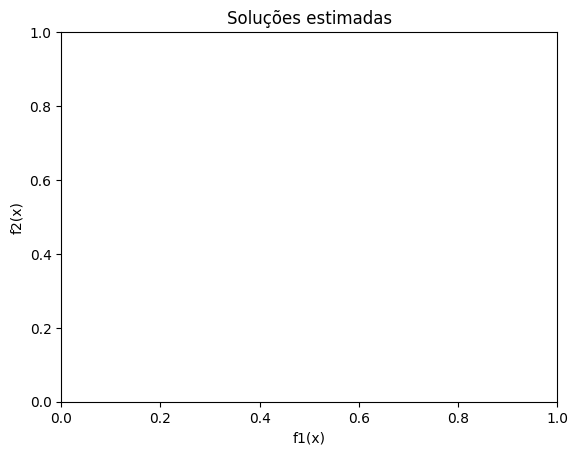

In [117]:
'''
Implementa uma metaheurística BVNS
'''

def bvns(f, max_num_sol_avaliadas):


  # Número de estruturas de vizinhanças definidas
  kmax = 4

  # Faz a leitura dos dados da instância do problema
  probdata = probdef()

  # Gera solução inicial
  initial_solution = generate_initial_solution(f)

 
  # Contador do número de soluções candidatas avaliadas
  min_episolon = 9#6891
  max_episolon = 25#56510

  # episolons = [random.randint(min_episolon, max_episolon) for _ in range(50)]

  # Ciclo iterativo do método
  for color in ["b.", "g.", "r.", "y.", "k."]:
    solucoes = []
    num_iteracoes = 0
    max_iteracoes = 50
    while len(solucoes) < 20 and num_iteracoes < max_iteracoes:
      if(num_iteracoes > max_iteracoes):
        break
      num_iteracoes += 1
      print ("Num Solucoes: {} Num Iteracoes {}".format(len(solucoes), num_iteracoes))

      num_sol_avaliadas = 1
      episolon = random.randint(min_episolon, max_episolon)
      x = fobj(initial_solution,probdata, f, episolon)
      fit = None
      globalX = None

      while num_sol_avaliadas < max_num_sol_avaliadas:

        k = 1
        while k <= kmax:

          # Gera uma solução candidata na k-ésima vizinhança de x
          y = shake(x,k)
          y = fobj(y,probdata, f, episolon)

          y = bestImprovement(y, kmax, probdata, f, episolon)
          num_sol_avaliadas += 1

          # Atualiza solução corrente e estrutura de vizinhança (se necessário)
          x,k = neighborhoodChange(x,y,k)
          if fit == None or fit >= x.fitness:
            fit = x.fitness
            globalX = x
          if num_sol_avaliadas > max_num_sol_avaliadas:
            break

      isNonDominatedSolution = nondominatedsolution(solucoes, [globalX.f1, globalX.f2])
      if(isNonDominatedSolution == True):
        solucoes.append(globalX)
        solucoes = removeDominatedSolutions(solucoes)

    for i in solucoes:
      print("f1 {} f2 {}".format(i.f1, i.f2))
      plt.plot(i.f1,i.f2,color)
plt.title('Soluções estimadas')
plt.xlabel('f1(x)')
plt.ylabel('f2(x)')
plt.show()



Num Solucoes: 0 Num Iteracoes 1
Num Solucoes: 1 Num Iteracoes 2
Num Solucoes: 2 Num Iteracoes 3
Num Solucoes: 3 Num Iteracoes 4
Num Solucoes: 3 Num Iteracoes 5
Num Solucoes: 3 Num Iteracoes 6
Num Solucoes: 4 Num Iteracoes 7
Num Solucoes: 4 Num Iteracoes 8
Num Solucoes: 5 Num Iteracoes 9
Num Solucoes: 6 Num Iteracoes 10
Num Solucoes: 6 Num Iteracoes 11
Num Solucoes: 6 Num Iteracoes 12
Num Solucoes: 7 Num Iteracoes 13
Num Solucoes: 7 Num Iteracoes 14
Num Solucoes: 8 Num Iteracoes 15
Num Solucoes: 8 Num Iteracoes 16
Num Solucoes: 8 Num Iteracoes 17
Num Solucoes: 9 Num Iteracoes 18
Num Solucoes: 9 Num Iteracoes 19
Num Solucoes: 9 Num Iteracoes 20
Num Solucoes: 9 Num Iteracoes 21
Num Solucoes: 9 Num Iteracoes 22
Num Solucoes: 9 Num Iteracoes 23
Num Solucoes: 9 Num Iteracoes 24
Num Solucoes: 9 Num Iteracoes 25
Num Solucoes: 10 Num Iteracoes 26
Num Solucoes: 10 Num Iteracoes 27
Num Solucoes: 10 Num Iteracoes 28
Num Solucoes: 9 Num Iteracoes 29
Num Solucoes: 8 Num Iteracoes 30
Num Solucoes: 9 

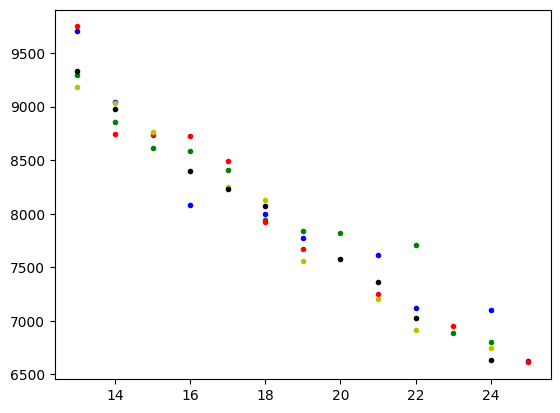

In [118]:
bvns("f1", 400)